In [1]:
WIDTH = 320
HEIGHT = 240
EPOCHS = 8
BATCH_SIZE = 8
TRAIN_KITTI_CSV = "D:/kitti_dataset/train/kitti_train.csv"
TRAIN_CUSTOM_CSV = "D:/dataset/train/data_train.csv"

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, LeakyReLU, BatchNormalization, UpSampling2D, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler

%run utils/datasets.ipynb
%run utils/utils.ipynb

In [ ]:
# KITTI U-Net

In [3]:
partition_kitti, labels_kitti = load_train_csv(TRAIN_KITTI_CSV)

In [4]:
print(len(partition_kitti['train']), len(partition_kitti['validation']))

4539 1135


In [5]:
training_generator_kitti = DataGenerator(list_IDs=partition_kitti['train'], labels=labels_kitti, batch_size=BATCH_SIZE,
                                   dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator_kitti = DataGenerator(list_IDs=partition_kitti['validation'], labels=labels_kitti, batch_size=BATCH_SIZE,
                                     dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [6]:
def downsampling_block(input_tensor, n_filters):
    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(input_tensor)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3,3), padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

def upsampling_block(input_tensor, n_filters, name, concat_with):
    x = UpSampling2D((2, 2), interpolation='bilinear', name=name)(input_tensor)
    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convA")(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = concatenate([x, concat_with], axis=3)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convB")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)

    x = Conv2D(filters=n_filters, kernel_size=(3, 3), padding='same', name=name+"_convC")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization()(x)
    return x

In [7]:
def build(height, width, depth):
    # input
    i = Input(shape=(height, width, depth))

    # encoder
    conv1 = downsampling_block(i, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = downsampling_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = downsampling_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = downsampling_block(pool3, 256)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    
    # bottleneck
    conv5 = Conv2D(512, (3, 3), padding='same')(pool4)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    conv5 = Conv2D(512, (3, 3), padding='same')(conv5)
    conv5 = LeakyReLU(alpha=0.2)(conv5)
    
    # decoder
    conv6 = upsampling_block(conv5, 256, "up1", concat_with=conv4)
    conv7 = upsampling_block(conv6, 128, "up2", concat_with=conv3)
    conv8 = upsampling_block(conv7, 64, "up3", concat_with=conv2)
    conv9 = upsampling_block(conv8, 32, "up4", concat_with=conv1)
    
    # output
    o = Conv2D(filters=1, kernel_size=3, strides=(1,1), activation='sigmoid', padding='same', name='conv10')(conv9)

    model = Model(inputs=i, outputs=o)
    return model

In [8]:
def poly_decay(epoch):
    maxEpochs = EPOCHS
    baseLR = INIT_LEARNING_RATE
    power = 1.0
    alpha = baseLR * (1 - (epoch / float(maxEpochs))) ** power
    return alpha

In [9]:
model_kitti = build(HEIGHT, WIDTH, 3)

In [10]:
model_kitti.compile(optimizer=opt,
              loss=lambda y_true, y_pred : gen_depth_loss(y_true, y_pred, (1.0,1.0,0.1)),
              metrics=[depth_acc])

In [11]:
unet_kitti = model_kitti.fit(training_generator_kitti, validation_data=validation_generator_kitti,
              epochs=EPOCHS, callbacks=[LearningRateScheduler(poly_decay)])

Epoch 1/8
567/567 [==============================] - 302s 518ms/step - loss: 0.1643 - depth_acc: 0.9091 - val_loss: 0.1463 - val_depth_acc: 0.9248 - lr: 1.0000e-04
Epoch 2/8
567/567 [==============================] - 248s 438ms/step - loss: 0.1296 - depth_acc: 0.9390 - val_loss: 0.1284 - val_depth_acc: 0.9443 - lr: 8.7500e-05
Epoch 3/8
567/567 [==============================] - 248s 438ms/step - loss: 0.1237 - depth_acc: 0.9449 - val_loss: 0.1281 - val_depth_acc: 0.9401 - lr: 7.5000e-05
Epoch 4/8
567/567 [==============================] - 248s 438ms/step - loss: 0.1206 - depth_acc: 0.9493 - val_loss: 0.1193 - val_depth_acc: 0.9504 - lr: 6.2500e-05
Epoch 5/8
567/567 [==============================] - 248s 437ms/step - loss: 0.1185 - depth_acc: 0.9528 - val_loss: 0.1169 - val_depth_acc: 0.9553 - lr: 5.0000e-05
Epoch 6/8
567/567 [==============================] - 249s 439ms/step - loss: 0.1168 - depth_acc: 0.9561 - val_loss: 0.1153 - val_depth_acc: 0.9581 - lr: 3.7500e-05
Epoch 7/8
567/56

In [12]:
print(unet_kitti.history)

{'loss': [0.164280965924263, 0.12955762445926666, 0.12365448474884033, 0.12061284482479095, 0.11853256076574326, 0.11675605922937393, 0.11495821177959442, 0.11399345844984055], 'depth_acc': [0.9090534448623657, 0.938967227935791, 0.9449291825294495, 0.9493116736412048, 0.9528257250785828, 0.9561437964439392, 0.9590712189674377, 0.9610939025878906], 'val_loss': [0.14628978073596954, 0.12839007377624512, 0.12810708582401276, 0.11932612210512161, 0.116877481341362, 0.1152501106262207, 0.1147029846906662, 0.11368579417467117], 'val_depth_acc': [0.9248180985450745, 0.9442674517631531, 0.9400942325592041, 0.9504067897796631, 0.9552648067474365, 0.95806485414505, 0.957267701625824, 0.960507869720459], 'lr': [1e-04, 8.75e-05, 7.5e-05, 6.25e-05, 5e-05, 3.75e-05, 2.5e-05, 1.25e-05]}


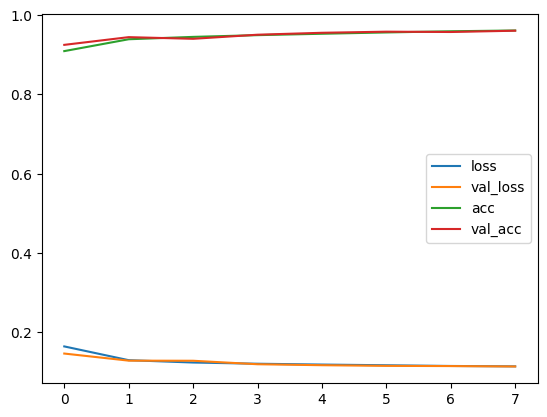

In [13]:
plot_history(unet_kitti.history)

In [15]:
print(save_model('kitti_unet', model_kitti))

model_kitti_unet_1719391955.keras


In [ ]:
# custom U-Net

In [14]:
partition_custom, labels_custom = load_train_csv(TRAIN_CUSTOM_CSV)

In [15]:
print(len(partition_custom['train']), len(partition_custom['validation']))

7532 1884


In [16]:
training_generator_custom = DataGenerator(list_IDs=partition_custom['train'], labels=labels_custom, batch_size=BATCH_SIZE,
                                   dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)
validation_generator_custom = DataGenerator(list_IDs=partition_custom['validation'], labels=labels_custom, batch_size=BATCH_SIZE,
                                     dim=(HEIGHT, WIDTH), n_channels=3, shuffle=True, pred=False)

In [17]:
model_custom = build(HEIGHT, WIDTH, 3)

In [18]:
model_custom.compile(optimizer=opt,
              loss=lambda y_true, y_pred : gen_depth_loss(y_true, y_pred, (1.0,1.0,0.1)),
              metrics=[depth_acc])

In [19]:
unet_custom = model_custom.fit(training_generator_custom, validation_data=validation_generator_custom,
              epochs=EPOCHS, callbacks=[LearningRateScheduler(poly_decay)])

Epoch 1/8
941/941 [==============================] - 474s 500ms/step - loss: 0.4336 - depth_acc: 0.7415 - val_loss: 0.4198 - val_depth_acc: 0.7518 - lr: 1.0000e-04
Epoch 2/8
941/941 [==============================] - 413s 439ms/step - loss: 0.4052 - depth_acc: 0.7877 - val_loss: 0.3873 - val_depth_acc: 0.8357 - lr: 8.7500e-05
Epoch 3/8
941/941 [==============================] - 413s 438ms/step - loss: 0.3822 - depth_acc: 0.8369 - val_loss: 0.3734 - val_depth_acc: 0.8512 - lr: 7.5000e-05
Epoch 4/8
941/941 [==============================] - 414s 439ms/step - loss: 0.3747 - depth_acc: 0.8443 - val_loss: 0.3727 - val_depth_acc: 0.8517 - lr: 6.2500e-05
Epoch 5/8
941/941 [==============================] - 413s 439ms/step - loss: 0.3701 - depth_acc: 0.8480 - val_loss: 0.3655 - val_depth_acc: 0.8517 - lr: 5.0000e-05
Epoch 6/8
941/941 [==============================] - 414s 440ms/step - loss: 0.3664 - depth_acc: 0.8503 - val_loss: 0.3646 - val_depth_acc: 0.8562 - lr: 3.7500e-05
Epoch 7/8
941/94

In [20]:
print(unet_custom.history)

{'loss': [0.4336123466491699, 0.4051717221736908, 0.3821726441383362, 0.37466299533843994, 0.3700740337371826, 0.3664294183254242, 0.3637213408946991, 0.3613804578781128], 'depth_acc': [0.7415471076965332, 0.7876503467559814, 0.8369231224060059, 0.844275176525116, 0.8479519486427307, 0.8503190875053406, 0.8517953753471375, 0.8536937832832336], 'val_loss': [0.41979506611824036, 0.38730236887931824, 0.37339743971824646, 0.37269628047943115, 0.3655450940132141, 0.3646484315395355, 0.36062830686569214, 0.35960471630096436], 'val_depth_acc': [0.7517513632774353, 0.8356752395629883, 0.8511840105056763, 0.8517200350761414, 0.8516961336135864, 0.856219470500946, 0.8571455478668213, 0.8582873344421387], 'lr': [1e-04, 8.75e-05, 7.5e-05, 6.25e-05, 5e-05, 3.75e-05, 2.5e-05, 1.25e-05]}


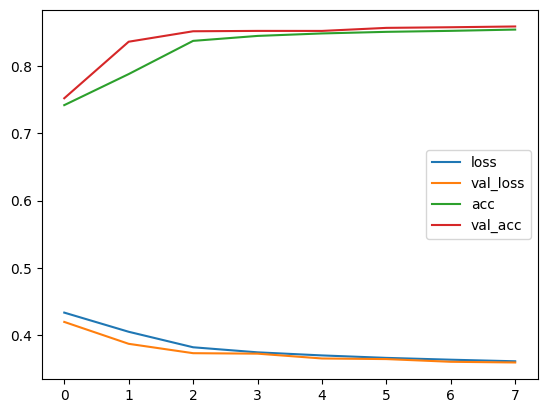

In [21]:
plot_history(unet_custom.history)

In [ ]:
# Combined history

In [22]:
def plot_combined_history(history1, history2):
    plt.figure(figsize=(12, 6))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'], label='KITTI Dataset Train Loss')
    plt.plot(history1.history['val_loss'], label='KITTI Dataset Val Loss')
    plt.plot(history2.history['loss'], label='Custom Dataset Train Loss')
    plt.plot(history2.history['val_loss'], label='Custom Dataset Val Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['depth_acc'], label='KITTI Dataset Train Accuracy')
    plt.plot(history1.history['val_depth_acc'], label='KITTI Dataset Val Accuracy')
    plt.plot(history2.history['depth_acc'], label='Custom Dataset Train Accuracy')
    plt.plot(history2.history['val_depth_acc'], label='Custom Dataset Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

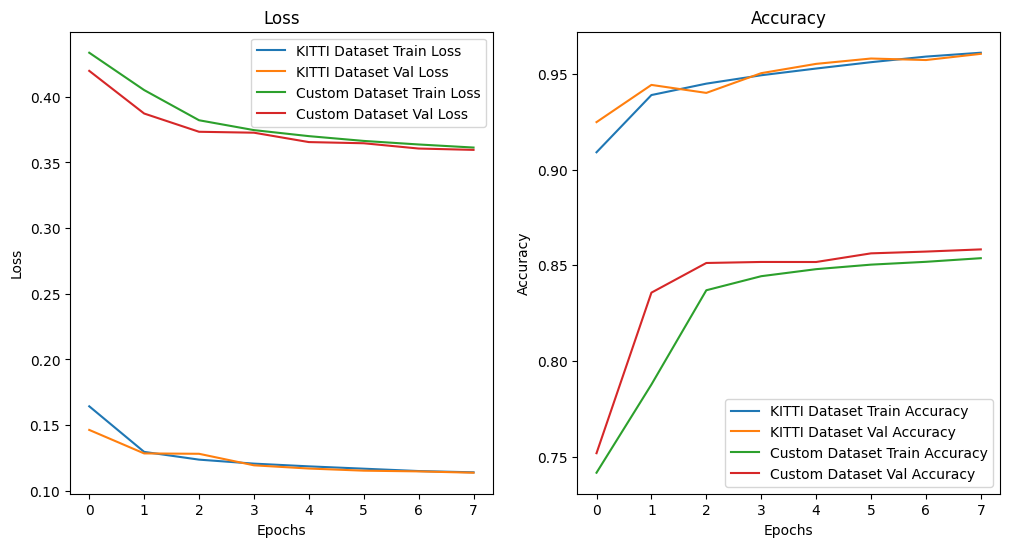

In [23]:
plot_combined_history(unet_kitti, unet_custom)